In [21]:
#pip install numpy 

In [22]:
#pip install scikit-learn

In [23]:
#pip install matplotlib

In [24]:
#pip install seaborn 

In [25]:
#pip install statsmodels

In [26]:
#pip install xgboost

In [27]:
#pip install mlflow


# Bibliotheken laden

In [28]:
# Bibliotheken importieren

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV

import xgboost as xgb
from xgboost import XGBRegressor

import mlflow
import mlflow.xgboost

#from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV # new import we need for this week

# Daten laden


In [ ]:
# Daten laden
df_train_clean = pd.read_pickle("./files/df_train_clean.parquet")
df_train_clean.head()

ModuleNotFoundError: No module named 'numpy._core.numeric'

In [ ]:
#df_train_clean['family'] = df_train_clean['family'].astype('category')
#df_train_clean['city'] = df_train_clean['city'].astype('category')
#df_train_clean['type'] = df_train_clean['type'].astype('category')
#df_train_clean['state'] = df_train_clean['state'].astype('category')

In [ ]:
df_train_clean.dtypes

id                              int64
date                   datetime64[ns]
store_nbr                       int64
item_nbr                        int64
unit_sales                    float64
onpromotion                      bool
is_outlier                       bool
year                            int32
month                           int32
day                             int32
day_of_week                     int32
family                         object
item_class                      int64
perishable                      int64
dcoilwtico                    float64
city                           object
state                          object
store_type                     object
sim_store_cluster               int64
holiday_type                   object
holiday_locale                 object
holiday_locale_name            object
holiday_description            object
holiday_transferred            object
transactions                  float64
lag_7                         float64
lag_30      

In [ ]:
df_train_clean.isnull().sum()

id                     0
date                   0
store_nbr              0
item_nbr               0
unit_sales             0
onpromotion            0
is_outlier             0
year                   0
month                  0
day                    0
day_of_week            0
family                 0
item_class             0
perishable             0
dcoilwtico             0
city                   0
state                  0
store_type             0
sim_store_cluster      0
holiday_type           0
holiday_locale         0
holiday_locale_name    0
holiday_description    0
holiday_transferred    0
transactions           0
lag_7                  0
lag_30                 0
lag_364                0
dtype: int64

# Feature Engineering

## Lags

In [ ]:
# Create lag features (e.g., sales from the previous day, previous week)
df_train_clean['lag_7'] = df_train_clean['unit_sales'].shift(7)
df_train_clean['lag_30'] = df_train_clean['unit_sales'].shift(30)
df_train_clean['lag_364'] = df_train_clean['unit_sales'].shift(364)

# Drop any rows with NaN values after creating lag features
df_train_clean.dropna(inplace=True)

In [ ]:
df_train_clean.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,year,month,day,...,sim_store_cluster,holiday_type,holiday_locale,holiday_locale_name,holiday_description,holiday_transferred,transactions,lag_7,lag_30,lag_364
364,19289,2013-01-02,24,587156,6.0,False,False,2013,1,2,...,1,0,0,0,0,0,2605.0,1.0,10.0,12.0
365,19290,2013-01-02,24,587186,14.0,False,False,2013,1,2,...,1,0,0,0,0,0,2605.0,3.0,21.0,2.0
366,19293,2013-01-02,24,592942,2.0,False,False,2013,1,2,...,1,0,0,0,0,0,2605.0,16.0,6.0,1.0
367,19295,2013-01-02,24,598414,13.0,False,False,2013,1,2,...,1,0,0,0,0,0,2605.0,22.0,4.0,7.0
368,19296,2013-01-02,24,598492,2.0,False,False,2013,1,2,...,1,0,0,0,0,0,2605.0,4.0,10.0,17.0


In [ ]:
df_train_clean.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'is_outlier', 'year', 'month', 'day', 'day_of_week', 'family',
       'item_class', 'perishable', 'dcoilwtico', 'city', 'state', 'store_type',
       'sim_store_cluster', 'holiday_type', 'holiday_locale',
       'holiday_locale_name', 'holiday_description', 'holiday_transferred',
       'transactions', 'lag_7', 'lag_30', 'lag_364'],
      dtype='object')

## rolling std/mean

In [ ]:
df_train_clean["date"] = pd.to_datetime(df_train_clean["date"])


In [ ]:
df_train_clean = df_train_clean.sort_values(["store_nbr", "item_nbr", "date"])

In [ ]:
df_train_clean["rolling_std_7d"] = (
    df_train_clean
    .groupby(["store_nbr", "item_nbr"])["unit_sales"] #Zeitreihen separat behandeln
    .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).std()) # transform sorgt dafür, dass die neue Spalte die gleiche Länge wie das Original hat.
)

In [ ]:
df_train_clean["rolling_std_30d"] = (
    df_train_clean
    .groupby(["store_nbr", "item_nbr"])["unit_sales"] #Zeitreihen separat behandeln
    .transform(lambda x: x.shift(1).rolling(window=30, min_periods=1).std()) # transform sorgt dafür, dass die neue Spalte die gleiche Länge wie das Original hat.
)

In [ ]:
df_train_clean["rolling_mean_7d"] = (
    df_train_clean
    .groupby(["store_nbr", "item_nbr"])["unit_sales"] #Zeitreihen separat behandeln
    .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()) # transform sorgt dafür, dass die neue Spalte die gleiche Länge wie das Original hat.
)

In [ ]:
df_train_clean["rolling_mean_30d"] = (
    df_train_clean
    .groupby(["store_nbr", "item_nbr"])["unit_sales"] #Zeitreihen separat behandeln
    .transform(lambda x: x.shift(1).rolling(window=30, min_periods=1).mean()) # transform sorgt dafür, dass die neue Spalte die gleiche Länge wie das Original hat.
)

In [ ]:
df_train_clean.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,year,month,day,...,holiday_transferred,transactions,lag_7,lag_30,lag_364,rolling_std_7d_lagged,rolling_mean_7d,rolling_std_30d,rolling_mean_30d,rolling_std_7d
68758,582436,2013-01-16,24,96995,1.0,False,False,2013,1,16,...,0,2555.0,45.0,9.0,15.0,0.000000,2.000000,0.000000,2.000000,NaN
73699,622071,2013-01-17,24,96995,2.0,False,False,2013,1,17,...,0,2557.0,10.0,1.0,2.0,0.577350,1.666667,0.577350,1.666667,NaN
88770,745650,2013-01-20,24,96995,3.0,False,False,2013,1,20,...,0,1908.0,6.0,1.0,11.0,0.500000,1.750000,0.500000,1.750000,0.707107
94161,787424,2013-01-21,24,96995,2.0,False,False,2013,1,21,...,0,2391.0,1.0,2.0,7.0,0.707107,2.000000,0.707107,2.000000,1.000000
113167,944616,2013-01-25,24,96995,2.0,False,False,2013,1,25,...,0,2586.0,3.0,7.0,1.0,0.632456,2.000000,0.632456,2.000000,0.816497


In [ ]:
# this is just a code snipped for how to group your dataframe first and then engineer the feature
#df_train_clean.groupby(by=['store_nbr', 'item_nbr'])['unit_sales'].shift(7).head(100)

In [ ]:
#df_train_indexed = df_train_clean.set_index(['store_nbr', 'item_nbr', 'date'])
#df_train_grouped = df_train_indexed.groupby(by=['store_nbr', 'item_nbr'])['unit_sales'].rolling(window=7).std().shift(7)
#df_train_grouped.head(10)

In [ ]:
# Drop any NaN values after creating rolling features
df_train_clean.dropna(inplace=True)

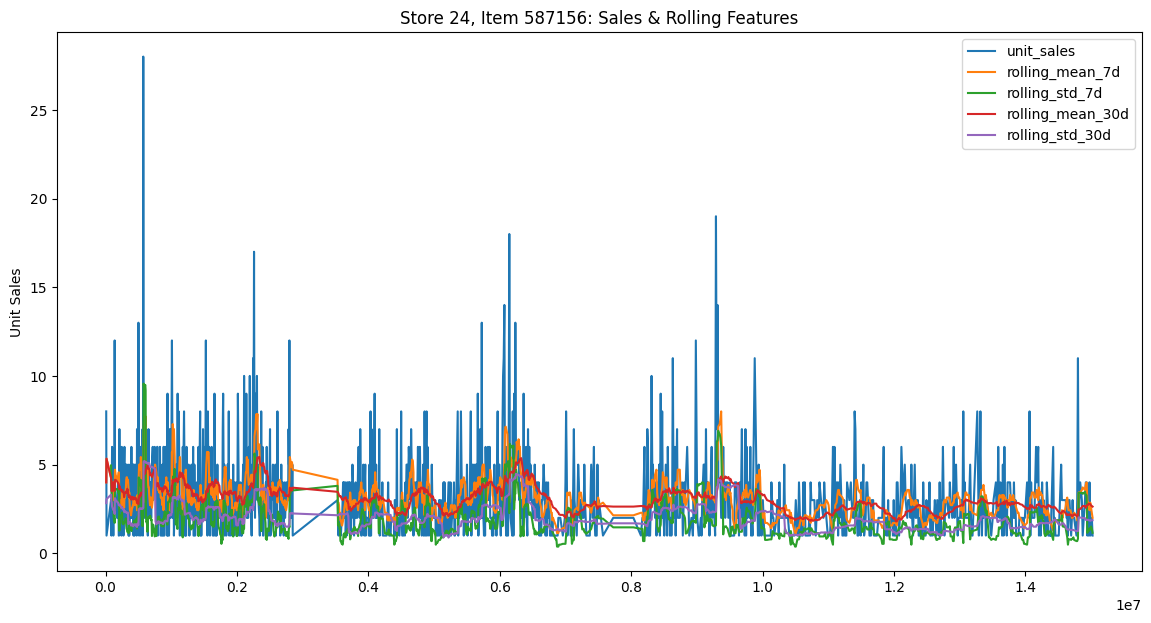

In [ ]:
# Beispiel: Store 24, Item 587156
store_id = 24
item_id = 587156

df_plot = df_train_clean[(df_train_clean["store_nbr"] == store_id) & 
                         (df_train_clean["item_nbr"] == item_id)]

df_plot = df_plot.sort_values("date")

# Plot: Original vs Rolling Features
df_plot[['unit_sales', 'rolling_mean_7d', 'rolling_std_7d', 
         'rolling_mean_30d', 'rolling_std_30d']].plot(figsize=(14, 7))

plt.title(f"Store {store_id}, Item {item_id}: Sales & Rolling Features")
plt.ylabel("Unit Sales")
plt.show()


## is_weekend

In [ ]:
df_train_clean.set_index('date', inplace=True)# Add date-based features
df_train_clean['day_of_week'] = df_train_clean.index.dayofweek
df_train_clean['month'] = df_train_clean.index.month
df_train_clean['is_weekend'] = df_train_clean['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [ ]:
df_train_clean.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,year,month,day,day_of_week,...,transactions,lag_7,lag_30,lag_364,rolling_std_7d_lagged,rolling_mean_7d,rolling_std_30d,rolling_mean_30d,rolling_std_7d,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2013-01-16,582436,24,96995,1.0,False,False,2013,1,16,2,...,2555.0,45.0,9.0,15.0,0.000000,2.000000,0.000000,2.000000,NaN,0
2013-01-17,622071,24,96995,2.0,False,False,2013,1,17,3,...,2557.0,10.0,1.0,2.0,0.577350,1.666667,0.577350,1.666667,NaN,0
2013-01-20,745650,24,96995,3.0,False,False,2013,1,20,6,...,1908.0,6.0,1.0,11.0,0.500000,1.750000,0.500000,1.750000,0.707107,1
2013-01-21,787424,24,96995,2.0,False,False,2013,1,21,0,...,2391.0,1.0,2.0,7.0,0.707107,2.000000,0.707107,2.000000,1.000000,0
2013-01-25,944616,24,96995,2.0,False,False,2013,1,25,4,...,2586.0,3.0,7.0,1.0,0.632456,2.000000,0.632456,2.000000,0.816497,0


# Encoding

In [34]:
df_train_ML_ready = pd.read_parquet("./df_train_ML_ready.parquet")
df_train_ML_ready.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,year,month,day,...,holiday_transferred,transactions,lag_7,lag_30,lag_364,rolling_7d_std,rolling_30d_std,rolling_7d_mean,rolling_30d_mean,is_weekend
0,2014-02-21,19281571,24,103520,2.0,False,False,2014,2,21,...,0,2455.0,10.0,3.0,6.0,6.658328,9.693522,9.000000,11.633333,0
1,2014-02-22,19331514,24,103520,8.0,False,False,2014,2,22,...,0,2291.0,10.0,3.0,16.0,2.751623,2.725992,5.714286,6.500000,1
2,2014-02-23,19382503,24,103520,3.0,False,False,2014,2,23,...,0,1419.0,8.0,4.0,7.0,18.442962,14.250791,22.142857,23.133333,1
3,2014-02-24,19432532,24,103520,1.0,False,False,2014,2,24,...,0,2247.0,4.0,5.0,1.0,3.716117,2.725782,4.857143,4.466667,0
4,2014-02-25,19481433,24,103520,6.0,False,False,2014,2,25,...,0,2192.0,2.0,4.0,2.0,11.338934,11.418074,31.714286,32.800000,0
